Problem Statement:
Build a sentiment analysis model using Recurrent Neural Networks (RNNs) t 
classify movie reviews from the IMDB dataset into positive or negative
sentiments.
Dataset:
The dataset comprises 25,000 movie reviews from IMDB, labeled by sent ment
(positive/negative). Reviews have been preprocessed, and each review is
encoded as a sequence of word indices (integers). The words in the data et are
indexed by overall frequency in the dataset, allowing for quick filtering op rations
such as: "only consider the top 10,000 most common words, but eliminat  the top
20 most common words".

Data Preprocessing: Load  IMDB dataset, keeping only the top 10,000 most requenty 
occurring words

In [1]:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense,Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
dataset, info = tfds.load('imdb_reviews', with_info=True,as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.JPE0T3_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.JPE0T3_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.JPE0T3_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [3]:
BUFFER_SIZE = 10000
BATCH_SIZE = 128
VOCAB_SIZE = 10000

Initially this returns a dataset of (text, label pairs):

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [5]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [6]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"I have been familiar with the fantastic book of 'Goodnight Mister Tom' for absolutely ages and it was only recently when I got the chance to watch this adaption of it. I have heard lots of positive remarks about this, so I had high hopes. Once this film had finished, I was horrified.<br /><br />This film is not a good film at all. 'Goodnight Mister Tom' was an extremely poor adaption and practically 4.5/10 of the book was missed out. Particularly, I found that a lot of the characters and some great scenes in the book were not in this. There was not much dialogue, It was rushed and far too fast-moving, but I was mostly upset by the fact that you never got to see the bonding and love between William Beech and Tom in this film which was a true let down. The casting was not all that good,either. I thought this could have been really good, but it was so different to the book! Anextremely poor adaption, one of the worst I've seen. This deserves a decent remake that'd better be 100

## Create the text encoder

In [7]:

encoder = tf.keras.layers.TextVectorization(max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [8]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U17')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [9]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10,  26,  75, ...,   0,   0,   0],
       [ 51,   9, 257, ...,   0,   0,   0],
       [ 48,   7,   4, ...,   0,   0,   0]])

In [10]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"I have been familiar with the fantastic book of 'Goodnight Mister Tom' for absolutely ages and it was only recently when I got the chance to watch this adaption of it. I have heard lots of positive remarks about this, so I had high hopes. Once this film had finished, I was horrified.<br /><br />This film is not a good film at all. 'Goodnight Mister Tom' was an extremely poor adaption and practically 4.5/10 of the book was missed out. Particularly, I found that a lot of the characters and some great scenes in the book were not in this. There was not much dialogue, It was rushed and far too fast-moving, but I was mostly upset by the fact that you never got to see the bonding and love between William Beech and Tom in this film which was a true let down. The casting was not all that good,either. I thought this could have been really good, but it was so different to the book! Anextremely poor adaption, one of the worst I've seen. This deserves a decent remake that'd better be 1

Model Building:

● Create a Sequential RNN model using TensorFlow and Keras.
● The model should consist of an Embedding layer, a SimpleRNN layer, a d
a Dense output layer.
● Compile the model, specifying the appropriate optimizer, loss function, and
mets.
Tr

In [11]:
model = tf.keras.Sequential([
    encoder,
    Embedding(input_dim=len(encoder.get_vocabulary()),output_dim=64,mask_zero=True), #Use masking to handle the variable sequence lengths
    Dropout(0.5),
    SimpleRNN(64),
    Dropout(0.5),
    Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.001)), #This layer increased the accuracy of the model
    Dropout(0.5),
    Dense(1)
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ ?                      │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [12]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [13]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics were out of this world. I would recommend this movie.')
predictions = model.predict(tf.constant([sample_text]))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[0.11408477]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [14]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(tf.constant([sample_text, padding]))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 854ms/step
[0.11408482]


Compile the Keras model to configure the training process:

In [15]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),optimizer=tf.keras.optimizers.Adam(1e-4),metrics=['accuracy'])

## Train the model

In [16]:
# Assuming your preprocessed data is in train_dataset
#Train the model on the preprocessed movie reviews, using a batch size of 128

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_dataset, epochs=100,validation_data=test_dataset,batch_size=128,validation_steps=30,callbacks=[early_stopping])

Epoch 1/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 269s 1s/step - accuracy: 0.4942 - loss: 0.7682 - val_accuracy: 0.4971 - val_loss: 0.7513
Epoch 2/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.5016 - loss: 0.7570 - val_accuracy: 0.5167 - val_loss: 0.7443
Epoch 3/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.4999 - loss: 0.7446 - val_accuracy: 0.4987 - val_loss: 0.7346
Epoch 4/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.5188 - loss: 0.7279 - val_accuracy: 0.7143 - val_loss: 0.6267
Epoch 5/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.7005 - loss: 0.6030 - val_accuracy: 0.6503 - val_loss: 0.6772
Epoch 6/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.6335 - loss: 0.6756 - val_accuracy: 0.7596 - val_loss: 0.5592
Epoch 7/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.8029 - loss: 0.4870 - val_accuracy: 0.8352 - val_loss: 0.4182
Epoch 8/100


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


196/196 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.8552 - loss: 0.3944 - val_accuracy: 0.8552 - val_loss: 0.3912
Epoch 9/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 264s 1s/step - accuracy: 0.8777 - loss: 0.3506 - val_accuracy: 0.8604 - val_loss: 0.3829
Epoch 10/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.8889 - loss: 0.3261 - val_accuracy: 0.8620 - val_loss: 0.3769
Epoch 11/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.9017 - loss: 0.2958 - val_accuracy: 0.8617 - val_loss: 0.3878
Epoch 12/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.9106 - loss: 0.2766 - val_accuracy: 0.8638 - val_loss: 0.3889
Epoch 13/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 266s 1s/step - accuracy: 0.9139 - loss: 0.2641 - val_accuracy: 0.8714 - val_loss: 0.3846
Epoch 14/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 259s 1s/step - accuracy: 0.9196 - loss: 0.2535 - val_accuracy: 0.8689 - val_loss: 0.3832
Epoch 15/100
196/196 ━━━━━━━━━━━━━━━━━━━━ 265s 1s/step - accuracy: 0.9221 - loss: 0.2439 - val_ac

In [17]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

196/196 ━━━━━━━━━━━━━━━━━━━━ 63s 320ms/step - accuracy: 0.8642 - loss: 0.3842
Test Loss: 0.379763662815094
Test Accuracy: 0.8648800253868103


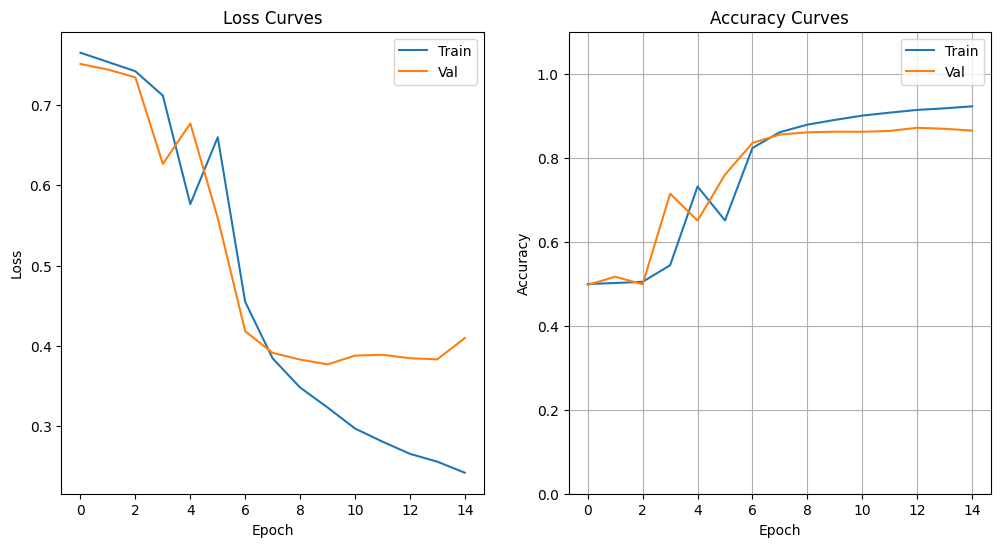

In [18]:
#Track accuracy
train_loss = history.history["loss"]
val_loss = history.history["val_loss"]

train_acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

plt.figure(figsize=(12, 6))
# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend(["Train", "Val"])


# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc)
plt.plot(val_acc)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.ylim(0,1.1)
plt.title("Accuracy Curves")
plt.legend(["Train", "Val"])


plt.grid()
plt.show()


Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [19]:
sample_text = ('The new movie was a complete disaster. The plot was nonsensical, the acting was wooden, and the special effects were laughable. The pacing was slow and the dialogue was cringe-worthy. I have never wasted two hours of my life so poorly. Avoid this movie at all costs.')
predictions = model.predict(tf.constant([sample_text]))[0][0]

sentiment = "Positive" if predictions >= 0.5 else "Negative"

print(sentiment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Negative


In [20]:
sample_text = ('The new movie was a delightful surprise. The captivating storyline, stellar performances, and stunning visuals kept me engaged throughout. The skillful storytelling of director and the dedication of actors shone through. A must-watch for movie lovers!')
predictions = model.predict(tf.constant([sample_text]))[0][0]
sentiment = "Positive" if predictions >= 0.5 else "Negative"

print(sentiment)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Positive
